In [1]:
from os.path import join, dirname, abspath
import yaml

import matplotlib.pyplot as plt

from pypsa import Network

from postprocessing.utils import *

import pickle

### Parameters

### Loading solved nets

In [2]:
main_case = '20210308_165137'
output_dir = f'../../output/epsilon_optimality/{main_case}/'
# Load base net
base_case = "base"
base_net = Network()
base_net.import_from_csv_folder(f"{output_dir}{base_case}/")
# Read config
config = yaml.load(open(f"{output_dir}/{base_case}/config.yaml", 'r'), Loader=yaml.FullLoader)
epsilons = config["epsilons"]
# Get links
# TODO: change to two different notebooks
links_ids = base_net.links.index
links_ids = base_net.buses.index
# Load alternative solutions
alternative_nets = {eps: {link: Network() for link in links_ids} for eps in epsilons}
cases = [base_case] + [f"{eps}_{link}" for link in links_ids for eps in epsilons]
for link in links_ids:
    for eps in epsilons:
        alternative_nets[eps][link].import_from_netcdf(f"{output_dir}{link}/{eps}/net.nc")

/home/duboisa1/miniconda3/envs/replan/lib/python3.7/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/duboisa1/miniconda3/envs/replan/lib/python3.7/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
/home/duboisa1/miniconda3/envs/replan/lib/python3.7/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.uni

## Network

name
BE-DE    1.00
BE-FR    4.30
BE-LU    0.68
BE-NL    3.40
DE-FR    4.50
DE-LU    2.30
DE-NL    5.00
FR-LU    0.38
Name: p_nom, dtype: float64
name
BE-DE    2.00
BE-FR    5.80
BE-LU    1.18
BE-NL    4.90
DE-FR    4.80
DE-LU    4.30
DE-NL    5.00
FR-LU    0.38
Name: p_nom_opt, dtype: float64


(<matplotlib.collections.PatchCollection at 0x7f1e89800d50>,
 <matplotlib.collections.LineCollection at 0x7f1e897fbf90>)

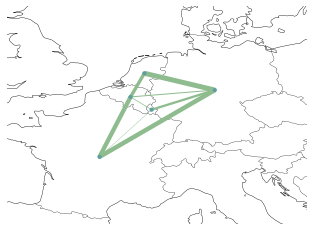

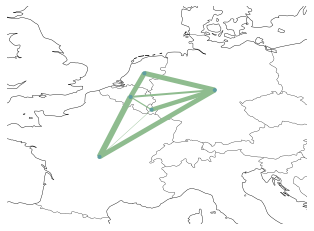

In [4]:
print(base_net.links.p_nom)
print(base_net.links.p_nom_opt)
base_net.plot(margin=0.8, link_widths=base_net.links.p_nom)
plt.figure()
base_net.plot(margin=0.8, link_widths=base_net.links.p_nom_opt)

### Costs

In [5]:
# Costs of generators
techs = ["ccgt", "load", "pv_utility", "ror",
         "wind_onshore", "wind_offshore"]
costs_eps_dict = dict.fromkeys(epsilons)
for eps in epsilons:
    eps_cases = [base_case] + [case.split("_")[1] for case in cases if case.startswith(str(eps))]
    # capex_opex = pd.DataFrame(index=["capex", "opex"], columns=eps_cases)
    costs_all = pd.DataFrame(index=["Generation", "Transmission", "Storage"], columns=eps_cases, dtype=float)
    for case in eps_cases:
        if case == base_case:
            net = base_net
        else:
            net = alternative_nets[eps][case]
        cost = get_generators_cost(net).sum() + get_links_capex(net).sum() + get_storage_cost(net).sum()
        costs_all.loc["Generation", case] = get_generators_cost(net).sum()
        # capex_opex.loc["capex", case] = get_links_capex(net).sum()
        # capex_opex.loc["opex", case] = get_storage_opex(net).sum()
        costs_all.loc["Transmission", case] = get_links_capex(net).sum()
        costs_all.loc["Storage", case] = get_storage_cost(net).sum()
    costs_all.loc["Total"] = costs_all.sum()
    costs_eps_dict[eps] = costs_all
    print('\n', eps)
    print(costs_all[base_case].round(2))
    print(costs_all[eps_cases[1:]].round(2))



 0.1
Generation      4.30
Transmission    0.01
Storage         0.01
Total           4.33
Name: base, dtype: float64
                BE    DE    FR    LU    NL
Generation    4.62  4.61  4.61  4.63  4.61
Transmission  0.00  0.01  0.01  0.01  0.01
Storage       0.13  0.15  0.14  0.13  0.14
Total         4.76  4.76  4.76  4.76  4.76


In [6]:
# Cost increase (%)
for eps in epsilons:
    eps_cases = [case.split("_")[1] for case in cases if case.startswith(str(eps))]
    costs_all = costs_eps_dict[eps]
    print(((costs_all.loc["Total", eps_cases]/costs_all.loc["Total", base_case] - 1).to_frame().T*100).round(2))

         BE    DE    FR    LU    NL
Total  9.97  9.97  9.97  9.97  9.97


## Capacities

0.1
               base   BE   DE   FR   LU   NL
ccgt            129  119  117  118  118  117
pv_utility       17   99  101  105  105  108
wind_onshore     57   98  103  104   97  101
wind_offshore   219  201  199  199  203  200
AC                2    1    1    1    1    2
Li-ion            0   74   81   78   70   74


<Figure size 432x288 with 0 Axes>

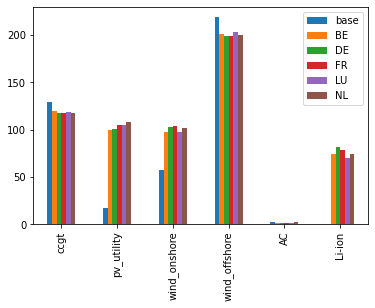

In [7]:
techs = ["ccgt", "pv_utility", "wind_onshore", "wind_offshore", "AC", "Li-ion"]

for eps in epsilons:
    eps_cases = [base_case] + [case.split("_")[1] for case in cases if case.startswith(str(eps))]
    capacities_df = pd.DataFrame(columns=eps_cases, index=techs, dtype=float)
    capacities_init_df = pd.DataFrame(columns=eps_cases, index=techs)
    for case in eps_cases:
        if case == base_case:
            net = base_net
        else:
            net = alternative_nets[eps][case]
        capacities = pd.concat([get_generators_capacity(net)["new"],
                                get_links_capacity(net)["new [TWkm]"], # + get_links_capacity(net)["init [TWkm]"],
                                get_storage_energy_capacity(net)["new [GWh]"]])
        for tech in techs:
            capacities_df.loc[tech, case] = capacities[capacities.index.str.startswith(tech)].sum()
        # capacities_df[case] = capacities[techs].round().values
        capacities = pd.concat([get_generators_capacity(net)["init"],
                                get_links_capacity(net)["init [TWkm]"],
                                get_storage_power_capacity(net)["init [GW]"]])
        capacities_init_df[case] = capacities[techs].values
    print(eps)
    print(capacities_df.round().astype(int))
    plt.figure()
    capacities_df.plot(kind="bar")

## Minimum capacity per link

In [8]:
for eps in epsilons:
    eps_cases = [base_case] + [case.split("_")[1] for case in cases if case.startswith(str(eps))]    
    links_capacities_new_df = pd.DataFrame(columns=eps_cases, index=links_ids, dtype=float)
    links_capacities_init_ds = pd.Series(index=links_ids, dtype=float)

    for case in eps_cases:
        if case == base_case:
            net = base_net
        else:
            net = alternative_nets[eps][case]
        links_capacities_new_df[case] = net.links.loc[links_ids].p_nom_opt - net.links.loc[links_ids].p_nom
        if case == base_case:
            links_capacities_init_ds = net.links.loc[links_ids].p_nom

    if eps == epsilons[0]:
        print("Initial capacity")
        print(links_capacities_init_ds)
    print()
    print(eps)
    print(links_capacities_new_df.round(2).T)

KeyError: "None of [Index(['BE', 'DE', 'FR', 'LU', 'NL'], dtype='object', name='name')] are in the [index]"

## Minimum sum of capacity of links adjacent to buses

In [9]:
# TODO: what is again the initial capacity used here?
# TODO: what is the max potential based on? TYNDP?

for eps in epsilons:
    eps_cases = [base_case] + [case.split("_")[1] for case in cases if case.startswith(str(eps))]    
    bus_links_capacities_new_df = pd.DataFrame(columns=eps_cases, index=links_ids, dtype=float)
    bus_links_capacities_init_ds = pd.Series(index=links_ids, dtype=float)

    for case in eps_cases:
        if case == base_case:
            net = base_net
        else:
            net = alternative_nets[eps][case]
        for bus in links_ids:
            adjacent_links = net.links[(net.links.bus0 == bus) | (net.links.bus1 == bus)].index
            bus_links_capacities_new_df.loc[bus, case] = (net.links.loc[adjacent_links].p_nom_opt 
                                                          - net.links.loc[adjacent_links].p_nom).sum()
            if case == base_case:
                bus_links_capacities_init_ds[bus] = net.links.loc[adjacent_links].p_nom.sum()

    if eps == epsilons[0]:
        print("Initial capacity")
        print(bus_links_capacities_init_ds)
    print()
    print(eps)
    print(bus_links_capacities_new_df.round(2).T)

Initial capacity
name
BE     9.38
DE    12.80
FR     9.18
LU     3.36
NL     8.40
dtype: float64

0.1
name    BE    DE    FR    LU    NL
base  4.50  3.30  1.80  2.50  1.50
BE    0.00  1.89  0.30  1.59  0.00
DE    3.21  0.00  1.44  0.39  1.38
FR    2.47  2.66  0.00  2.16  1.35
LU    3.44  0.94  1.68  0.00  1.31
NL    2.68  2.99  1.78  2.21  0.00
